In [1]:
import torch

#imports necessary to define a neural network 
import torch.nn as nn
import torch.nn.functional as F

#ensure you are using GPU.
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)

dtype = torch.cuda.FloatTensor
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

cuda:0


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(-0.5,0.5)])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/home/mohammad/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


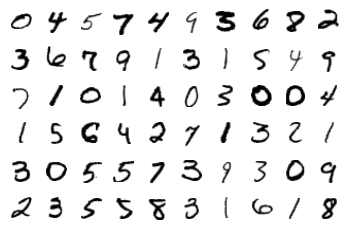

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
logps = model(images.reshape([64,1,28,28]).cuda()) #log probabilities
loss = criterion(logps, labels.cuda()) #calculate the NLL loss

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.reshape([-1,1,28,28]).cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 0 - Training loss: 1.054487051581269

Training Time (in minutes) = 0.09986407359441121
Epoch 1 - Training loss: 0.4296170888361392

Training Time (in minutes) = 0.19950389862060547
Epoch 2 - Training loss: 0.34607321034267

Training Time (in minutes) = 0.30101222594579063
Epoch 3 - Training loss: 0.30589389079002177

Training Time (in minutes) = 0.40597699880599974
Epoch 4 - Training loss: 0.2773636725824525

Training Time (in minutes) = 0.509467613697052
Epoch 5 - Training loss: 0.258386384640167

Training Time (in minutes) = 0.6131433447202047
Epoch 6 - Training loss: 0.23890492706490096

Training Time (in minutes) = 0.7178377707799276
Epoch 7 - Training loss: 0.22986116852047347

Training Time (in minutes) = 0.8197766065597534
Epoch 8 - Training loss: 0.21903355783626025

Training Time (in minutes) = 0.9185047666231791
Epoch 9 - Training loss: 0.20840795196767556

Training Time (in minutes) = 1.0175398111343383
Epoch 10 - Training loss: 0.2015412354778284

Training Time (in mi

Predicted Digit = 7


<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


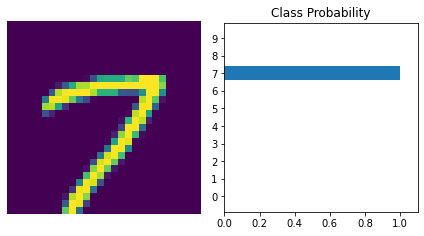

In [9]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
images, labels = next(iter(valloader))

img = images[0].reshape([-1,1,28,28])
with torch.no_grad():
    logps = model(img.cuda())

ps = torch.exp(logps)
probab = list(ps.detach().cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [10]:
torch.exp(model(img.cuda()))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[3.5439e-16, 7.0265e-19, 1.2701e-11, 1.0988e-10, 2.4161e-14, 8.6821e-11,
         3.1597e-23, 1.0000e+00, 6.5452e-14, 2.7657e-09]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [11]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].reshape([-1,1,28,28])
    with torch.no_grad():
        logps = model(img.cuda())

    
    ps = torch.exp(logps)
    probab = list(ps.detach().cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Number Of Images Tested = 10000

Model Accuracy = 0.954


In [12]:
images.shape

torch.Size([16, 1, 28, 28])

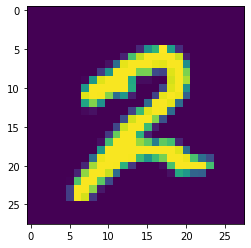

In [13]:
plt.imshow(img.detach().cpu().numpy().reshape(28,28))

In [64]:
def findloss(diff,pred):
    
#     diff is array of noise
#     pred is the prediction of the above trained model
    
    
    l1=(torch.square(diff))
    l1=torch.mean(l1)
    
    l2=pred**(-2)/1e4
    
    fl=l1+l2
    fl=fl**0.5
    
    return fl

In [65]:
diff=torch.rand([784]).cuda().requires_grad_()

In [66]:
learning_rate=0.00005
num_descents=40000000 #number of times gradient descent is employed

img=img.reshape(784).cuda()

for i in range(num_descents):
    
    imagef=img+diff
    pred=torch.exp(model(imagef.reshape([-1,1,28,28])))[0][8]
    totalloss=findloss(diff,pred)
    if i%10000 ==0:
        print('Loss and prediction by the model after '+str(i)+' steps of gradient descent are '+str(totalloss.item()),str(pred.item()))

    #find gradients of totalt wrt yarray.
    totalloss.backward()

    gradients=diff.grad
    with torch.no_grad():
        diff[1:]=diff[1:]-learning_rate*gradients[1:]
        
        
    diff.grad.data.zero_()

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Loss and prediction by the model after 0 steps of gradient descent are 0.6074830293655396 0.06414470076560974
Loss and prediction by the model after 10000 steps of gradient descent are 0.7411953806877136 0.39648962020874023
Loss and prediction by the model after 20000 steps of gradient descent are 0.7403720021247864 0.9749667048454285
Loss and prediction by the model after 30000 steps of gradient descent are 0.7397850751876831 0.9426537752151489
Loss and prediction by the model after 40000 steps of gradient descent are 0.7400489449501038 0.2680071294307709
Loss and prediction by the model after 50000 steps of gradient descent are 0.738592267036438 0.9722388982772827
Loss and prediction by the model after 60000 steps of gradient descent are 0.738010823726654 0.9761130213737488
Loss and prediction by the model after 70000 steps of gradient descent are 0.7374500036239624 0.9017658233642578
Loss and prediction by the model after 80000 steps of gradient descent are 0.7368385791778564 0.9912

Loss and prediction by the model after 730000 steps of gradient descent are 0.6984655857086182 0.876376211643219
Loss and prediction by the model after 740000 steps of gradient descent are 0.697870135307312 0.9644328355789185
Loss and prediction by the model after 750000 steps of gradient descent are 0.6972860097885132 0.9972715973854065
Loss and prediction by the model after 760000 steps of gradient descent are 0.6967243552207947 0.8948680758476257
Loss and prediction by the model after 770000 steps of gradient descent are 0.6961249709129333 0.998038113117218
Loss and prediction by the model after 780000 steps of gradient descent are 0.6955479383468628 0.9998045563697815
Loss and prediction by the model after 790000 steps of gradient descent are 0.6973645687103271 0.1707283854484558
Loss and prediction by the model after 800000 steps of gradient descent are 0.6943972706794739 0.9922091960906982
Loss and prediction by the model after 810000 steps of gradient descent are 0.6938392519950

Loss and prediction by the model after 1450000 steps of gradient descent are 0.657039999961853 0.9999775290489197
Loss and prediction by the model after 1460000 steps of gradient descent are 0.6564981341362 0.8376306295394897
Loss and prediction by the model after 1470000 steps of gradient descent are 0.6558922529220581 0.9985346794128418
Loss and prediction by the model after 1480000 steps of gradient descent are 0.6553246378898621 0.9510308504104614
Loss and prediction by the model after 1490000 steps of gradient descent are 0.6547876596450806 0.7896304130554199
Loss and prediction by the model after 1500000 steps of gradient descent are 0.6541703939437866 0.993952214717865
Loss and prediction by the model after 1510000 steps of gradient descent are 0.6535972952842712 0.9764919281005859
Loss and prediction by the model after 1520000 steps of gradient descent are 0.6530267000198364 0.9879735708236694
Loss and prediction by the model after 1530000 steps of gradient descent are 0.652515

Loss and prediction by the model after 2170000 steps of gradient descent are 0.6157715916633606 0.9719710350036621
Loss and prediction by the model after 2180000 steps of gradient descent are 0.6151958703994751 0.9727122783660889
Loss and prediction by the model after 2190000 steps of gradient descent are 0.6146228313446045 0.9535028338432312
Loss and prediction by the model after 2200000 steps of gradient descent are 0.6140499711036682 0.9558911323547363
Loss and prediction by the model after 2210000 steps of gradient descent are 0.6134644746780396 0.9998538494110107
Loss and prediction by the model after 2220000 steps of gradient descent are 0.6130626797676086 0.5641770362854004
Loss and prediction by the model after 2230000 steps of gradient descent are 0.6123190522193909 0.9986355304718018
Loss and prediction by the model after 2240000 steps of gradient descent are 0.6117417812347412 0.9999946355819702
Loss and prediction by the model after 2250000 steps of gradient descent are 0.6

Loss and prediction by the model after 2890000 steps of gradient descent are 0.5742842555046082 0.8131111264228821
Loss and prediction by the model after 2900000 steps of gradient descent are 0.5736806988716125 0.9033458232879639
Loss and prediction by the model after 2910000 steps of gradient descent are 0.5731051564216614 0.8969506621360779
Loss and prediction by the model after 2920000 steps of gradient descent are 0.5725113749504089 0.9719971418380737
Loss and prediction by the model after 2930000 steps of gradient descent are 0.5719289183616638 0.9982343912124634
Loss and prediction by the model after 2940000 steps of gradient descent are 0.5713484883308411 0.996943473815918
Loss and prediction by the model after 2950000 steps of gradient descent are 0.570774257183075 0.9837610125541687
Loss and prediction by the model after 2960000 steps of gradient descent are 0.5701913237571716 0.9954717755317688
Loss and prediction by the model after 2970000 steps of gradient descent are 0.569

Loss and prediction by the model after 3610000 steps of gradient descent are 0.5330389142036438 0.7579405903816223
Loss and prediction by the model after 3620000 steps of gradient descent are 0.5324264168739319 0.8688399791717529
Loss and prediction by the model after 3630000 steps of gradient descent are 0.5322825908660889 0.41208121180534363
Loss and prediction by the model after 3640000 steps of gradient descent are 0.53131103515625 0.7886173129081726
Loss and prediction by the model after 3650000 steps of gradient descent are 0.5306892991065979 0.9928259253501892
Loss and prediction by the model after 3660000 steps of gradient descent are 0.5301222801208496 0.9998748302459717
Loss and prediction by the model after 3670000 steps of gradient descent are 0.5295486450195312 0.9992870092391968
Loss and prediction by the model after 3680000 steps of gradient descent are 0.5289809703826904 0.9959454536437988
Loss and prediction by the model after 3690000 steps of gradient descent are 0.52

Loss and prediction by the model after 4330000 steps of gradient descent are 0.4923497140407562 0.9939544200897217
Loss and prediction by the model after 4340000 steps of gradient descent are 0.49179452657699585 0.9992972016334534
Loss and prediction by the model after 4350000 steps of gradient descent are 0.4922948181629181 0.294891893863678
Loss and prediction by the model after 4360000 steps of gradient descent are 0.49070921540260315 0.8720273375511169
Loss and prediction by the model after 4370000 steps of gradient descent are 0.49011820554733276 0.9969767928123474
Loss and prediction by the model after 4380000 steps of gradient descent are 0.48955145478248596 0.9988832473754883
Loss and prediction by the model after 4390000 steps of gradient descent are 0.4889923334121704 0.9999376535415649
Loss and prediction by the model after 4400000 steps of gradient descent are 0.4884398579597473 0.9989058971405029
Loss and prediction by the model after 4410000 steps of gradient descent are 

Loss and prediction by the model after 5050000 steps of gradient descent are 0.45264068245887756 0.9889603853225708
Loss and prediction by the model after 5060000 steps of gradient descent are 0.45217254757881165 0.7479708194732666
Loss and prediction by the model after 5070000 steps of gradient descent are 0.452239066362381 0.37016505002975464
Loss and prediction by the model after 5080000 steps of gradient descent are 0.4511036276817322 0.7071216106414795
Loss and prediction by the model after 5090000 steps of gradient descent are 0.4504639804363251 0.8908933401107788
Loss and prediction by the model after 5100000 steps of gradient descent are 0.44989514350891113 0.9715358018875122
Loss and prediction by the model after 5110000 steps of gradient descent are 0.4493601322174072 0.9101072549819946
Loss and prediction by the model after 5120000 steps of gradient descent are 0.44891369342803955 0.7034676671028137
Loss and prediction by the model after 5130000 steps of gradient descent are

Loss and prediction by the model after 5770000 steps of gradient descent are 0.4139348268508911 0.9971844553947449
Loss and prediction by the model after 5780000 steps of gradient descent are 0.4133801758289337 0.994024395942688
Loss and prediction by the model after 5790000 steps of gradient descent are 0.41285228729248047 0.9906386137008667
Loss and prediction by the model after 5800000 steps of gradient descent are 0.4123106300830841 0.9998214840888977
Loss and prediction by the model after 5810000 steps of gradient descent are 0.4119669497013092 0.6165210008621216
Loss and prediction by the model after 5820000 steps of gradient descent are 0.41123008728027344 0.9868899583816528
Loss and prediction by the model after 5830000 steps of gradient descent are 0.410675585269928 0.9911271929740906
Loss and prediction by the model after 5840000 steps of gradient descent are 0.410160094499588 0.9274881482124329
Loss and prediction by the model after 5850000 steps of gradient descent are 0.40

Loss and prediction by the model after 6490000 steps of gradient descent are 0.3741622865200043 0.7095600366592407
Loss and prediction by the model after 6500000 steps of gradient descent are 0.3734702169895172 0.9684703350067139
Loss and prediction by the model after 6510000 steps of gradient descent are 0.37287500500679016 0.9999052882194519
Loss and prediction by the model after 6520000 steps of gradient descent are 0.3723025321960449 0.9979071617126465
Loss and prediction by the model after 6530000 steps of gradient descent are 0.37176182866096497 0.8492884635925293
Loss and prediction by the model after 6540000 steps of gradient descent are 0.37115615606307983 0.9986690878868103
Loss and prediction by the model after 6550000 steps of gradient descent are 0.37059423327445984 0.9643450379371643
Loss and prediction by the model after 6560000 steps of gradient descent are 0.3701602518558502 0.6762418150901794
Loss and prediction by the model after 6570000 steps of gradient descent are

Loss and prediction by the model after 7200000 steps of gradient descent are 0.3327881693840027 0.6506374478340149
Loss and prediction by the model after 7210000 steps of gradient descent are 0.3319994807243347 0.9773258566856384
Loss and prediction by the model after 7220000 steps of gradient descent are 0.3331470787525177 0.28371819853782654
Loss and prediction by the model after 7230000 steps of gradient descent are 0.33090442419052124 0.8499352335929871
Loss and prediction by the model after 7240000 steps of gradient descent are 0.3302901089191437 0.9379998445510864
Loss and prediction by the model after 7250000 steps of gradient descent are 0.32971152663230896 0.9531608819961548
Loss and prediction by the model after 7260000 steps of gradient descent are 0.329127699136734 0.9802190065383911
Loss and prediction by the model after 7270000 steps of gradient descent are 0.3285800516605377 0.8864484429359436
Loss and prediction by the model after 7280000 steps of gradient descent are 0

Loss and prediction by the model after 7920000 steps of gradient descent are 0.3024730682373047 0.1304311454296112
Loss and prediction by the model after 7930000 steps of gradient descent are 0.2922426164150238 0.9559184312820435
Loss and prediction by the model after 7940000 steps of gradient descent are 0.29223012924194336 0.4903159737586975
Loss and prediction by the model after 7950000 steps of gradient descent are 0.2913396954536438 0.7004358172416687
Loss and prediction by the model after 7960000 steps of gradient descent are 0.29062357544898987 0.9763832688331604
Loss and prediction by the model after 7970000 steps of gradient descent are 0.2901464104652405 0.8550482988357544
Loss and prediction by the model after 7980000 steps of gradient descent are 0.28975552320480347 0.6646131277084351
Loss and prediction by the model after 7990000 steps of gradient descent are 0.28906774520874023 0.8501378297805786
Loss and prediction by the model after 8000000 steps of gradient descent are

Loss and prediction by the model after 8630000 steps of gradient descent are 0.25645244121551514 0.747106671333313
Loss and prediction by the model after 8640000 steps of gradient descent are 0.2563815116882324 0.5073428750038147
Loss and prediction by the model after 8650000 steps of gradient descent are 0.2567630112171173 0.34455037117004395
Loss and prediction by the model after 8660000 steps of gradient descent are 0.2548738420009613 0.9087705016136169
Loss and prediction by the model after 8670000 steps of gradient descent are 0.2559967041015625 0.32494136691093445
Loss and prediction by the model after 8680000 steps of gradient descent are 0.25464892387390137 0.44583094120025635
Loss and prediction by the model after 8690000 steps of gradient descent are 0.25337135791778564 0.9947347044944763
Loss and prediction by the model after 8700000 steps of gradient descent are 0.2542581856250763 0.3549342155456543
Loss and prediction by the model after 8710000 steps of gradient descent ar

Loss and prediction by the model after 9340000 steps of gradient descent are 0.22414062917232513 0.6307467222213745
Loss and prediction by the model after 9350000 steps of gradient descent are 0.2235068827867508 0.8802911639213562
Loss and prediction by the model after 9360000 steps of gradient descent are 0.22306078672409058 0.906562089920044
Loss and prediction by the model after 9370000 steps of gradient descent are 0.22274810075759888 0.7589889764785767
Loss and prediction by the model after 9380000 steps of gradient descent are 0.22238853573799133 0.6976187825202942
Loss and prediction by the model after 9390000 steps of gradient descent are 0.22194501757621765 0.6901302933692932
Loss and prediction by the model after 9400000 steps of gradient descent are 0.22129328548908234 0.9566895365715027
Loss and prediction by the model after 9410000 steps of gradient descent are 0.22090454399585724 0.9999610185623169
Loss and prediction by the model after 9420000 steps of gradient descent a

Loss and prediction by the model after 10050000 steps of gradient descent are 0.1962539702653885 0.9623996019363403
Loss and prediction by the model after 10060000 steps of gradient descent are 0.1959318369626999 0.995158851146698
Loss and prediction by the model after 10070000 steps of gradient descent are 0.19562630355358124 0.878131628036499
Loss and prediction by the model after 10080000 steps of gradient descent are 0.1952362358570099 0.9748936295509338
Loss and prediction by the model after 10090000 steps of gradient descent are 0.19502846896648407 0.8288817405700684
Loss and prediction by the model after 10100000 steps of gradient descent are 0.19459249079227448 0.9998683929443359
Loss and prediction by the model after 10110000 steps of gradient descent are 0.19422607123851776 0.9600477814674377
Loss and prediction by the model after 10120000 steps of gradient descent are 0.19417092204093933 0.6676244735717773
Loss and prediction by the model after 10130000 steps of gradient des

Loss and prediction by the model after 10760000 steps of gradient descent are 0.174916610121727 0.9549530148506165
Loss and prediction by the model after 10770000 steps of gradient descent are 0.17548562586307526 0.4962983727455139
Loss and prediction by the model after 10780000 steps of gradient descent are 0.17440497875213623 0.8611136674880981
Loss and prediction by the model after 10790000 steps of gradient descent are 0.7669710516929626 0.013386309146881104
Loss and prediction by the model after 10800000 steps of gradient descent are 0.17389635741710663 0.9995191097259521
Loss and prediction by the model after 10810000 steps of gradient descent are 0.1736632138490677 0.8437511920928955
Loss and prediction by the model after 10820000 steps of gradient descent are 0.17321372032165527 0.9999107122421265
Loss and prediction by the model after 10830000 steps of gradient descent are 0.18910931050777435 0.1298094391822815
Loss and prediction by the model after 10840000 steps of gradient 

Loss and prediction by the model after 11470000 steps of gradient descent are 0.15850937366485596 0.7260699272155762
Loss and prediction by the model after 11480000 steps of gradient descent are 0.15809383988380432 0.999543309211731
Loss and prediction by the model after 11490000 steps of gradient descent are 0.1711796224117279 0.1494193971157074
Loss and prediction by the model after 11500000 steps of gradient descent are 0.15825548768043518 0.5914369225502014
Loss and prediction by the model after 11510000 steps of gradient descent are 0.1577170193195343 0.8087450265884399
Loss and prediction by the model after 11520000 steps of gradient descent are 0.15734080970287323 0.9758214950561523
Loss and prediction by the model after 11530000 steps of gradient descent are 0.15709394216537476 0.9728158712387085
Loss and prediction by the model after 11540000 steps of gradient descent are 0.15777099132537842 0.5231310129165649
Loss and prediction by the model after 11550000 steps of gradient d

KeyboardInterrupt: 

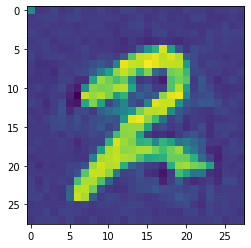

In [67]:
plt.imshow(imagef.detach().cpu().numpy().reshape(28,28))

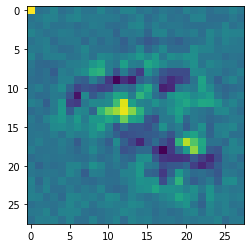

In [68]:
plt.imshow(diff.detach().cpu().numpy().reshape(28,28))

In [52]:
learning_rate=0.00001
num_descents=6000000 #number of times gradient descent is employed

img=img.reshape(784).cuda()

for i in range(1080000,num_descents):
    
    imagef=img+diff
    pred=torch.exp(model(imagef.reshape([-1,1,28,28])))[0][8]
    totalloss=findloss(diff,pred)
    if i%10000 ==0:
        print('Loss and prediction by the model after '+str(i)+' steps of gradient descent are '+str(totalloss.item()),str(pred.item()))

    #find gradients of totalt wrt yarray.
    totalloss.backward()

    gradients=diff.grad
    with torch.no_grad():
        diff[1:]=diff[1:]-learning_rate*gradients[1:]
        
        
    diff.grad.data.zero_()

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Loss and prediction by the model after 1080000 steps of gradient descent are 0.5179365873336792 0.5206899046897888
Loss and prediction by the model after 1090000 steps of gradient descent are 0.5179376602172852 0.6639869213104248
Loss and prediction by the model after 1100000 steps of gradient descent are 0.5179382562637329 0.9865331649780273
Loss and prediction by the model after 1110000 steps of gradient descent are 0.5179411172866821 0.6558887362480164
Loss and prediction by the model after 1120000 steps of gradient descent are 0.5179430842399597 0.7715947031974792
Loss and prediction by the model after 1130000 steps of gradient descent are 0.5179464817047119 0.9635094404220581
Loss and prediction by the model after 1140000 steps of gradient descent are 0.5179803967475891 0.18859560787677765
Loss and prediction by the model after 1150000 steps of gradient descent are 0.5179645419120789 0.9873834848403931


KeyboardInterrupt: 

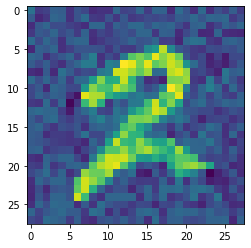

In [53]:
plt.imshow(imagef.detach().cpu().numpy().reshape(28,28))

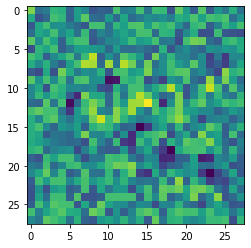

In [54]:
plt.imshow(diff.detach().cpu().numpy().reshape(28,28))